# Parametrizations
In this chapter, we will see how to use parametrizations in MOAI. Parametrizations are at the heart of MOAI's philosophy: they are what makes it modular. They can be used for pretty much anything. They are also recursive, i.e. a parametrization can call another one, which can itself call another one... etc. When it comes to parametrizations in MOAI, your imagination is the only limit!

## What are parametrizations?
We have already used parametrizations in this tutorial (every time we called the setParametrization method of the magma ocean object), although we haven't spent much time explaining in detail what we were doing. A parametrization is simply a quantity that you want to track which is not included in the built in traced quantities of the magma ocean (like the bottom pressure or the density). You simply need to tell the magma ocean object how to calculate this quantity (what's the formula), and which other quantities you need to do the calculation. Then, this new quantity will be made available to calculate yet other new ones. Let's take an example:

In the previous chapter (on speciation), we needed to track the oxygen fugacity ($f_{{\rm O}_2}$). We assumed that it was set by the IW buffer, so we used an expression (from Hirschmann 2021):   
$$\log f_{{\rm O}_2}=a(p)+b(p)T+c(p)T\ln T+d(p)/T$$
where the parameters $a$, $b$, $c$ and $d$ are each proportional to a different 3$^{\rm rd}$ order polynomial in $p$ plus a square root term. So the $f_{{\rm O}_2}$ depends on the temperature and pressure, which are both built-in accessible quantities of the magma ocean object. You can calculate the $f_{{\rm O}_2}$ at the surface of the MO, using the $p_{\rm sfc}$ and $T_{\rm pot}$ attributes, but you can also calculate the complete $f_{{\rm O}_2}$ profile through the MO, using the temperature profile along the adiabat. Let's now see how to implement either of these possibilities.

## Setting a new parametrization

As usual, we first need a MO:

In [2]:
from MO_lib.eq_basic import MO
MO.updateT_pot(3000)

No file found: calculating lookups, be patient it can take some time!


### Surface $f_{{\rm O}_2}$
The only method you need to call to set up a parametrization is setParametrization:

In [7]:
from chemistry.redox import fO2_buffers_H22                                       # this is the function implementing equation (1)
MO.setParametrization('fO2_surface',                                              # name of the parametrization
                      lambda var:10**fO2_buffers_H22(var['p_sfc'],var['T_pot']),  # the function itself; notice that it needs to be defined as a function of a dictionnary ("var")
                      ['p_sfc','T_pot'],                                          # the list of variables you need to include in the argument dictionnary var
                      is_profile=False)                                           # does th eparametrization calculate a profile? No (by default yes)

# The value is store in MO.averages (for scalar parametrizations):
print(MO.averages['fO2_surface'])

0.0027389957633508484


Each time you update the internal state of the MO, either by calling RK4_step or simply updateT_pot (or updateState if know what you're doing), the value of fO2_surface will be updated according to the new $T_{\rm pot}$ and $p_{\rm sfc}$.

### $f_{{\rm O}_2}$ profile
If we want to know the whole profile of $f_{{\rm O}_2}$, it is very similar: we just need to ask the parametrization to read the pressure and temperature profiles rather than their surface value:

Text(0, 0.5, 'pressure [GPa]')

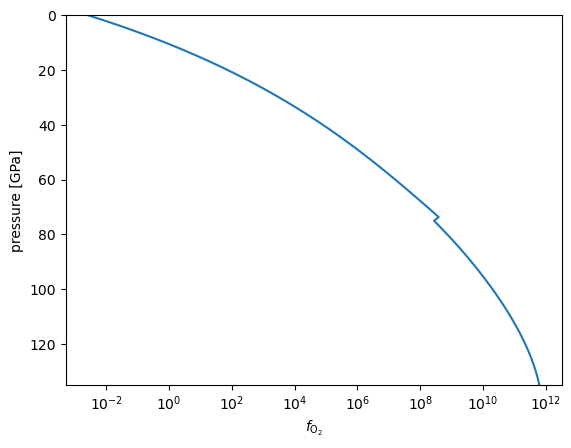

In [12]:
# we just need to vectorize fO2_buffers_H22 so that it can read p and T as vector rather than scalars
import numpy as np
fO2_buffers_H22_vec = np.vectorize(fO2_buffers_H22)

MO.setParametrization('fO2_profile',
                      lambda var:10**fO2_buffers_H22_vec(var['pressures'],var['temperatures']),
                      ['pressures','temperatures'], # The pressures and temperature profiles are simply called... "pressures" and "temperatures"
                      is_profile=True)              # This time it is a profile.

# The value is store in MO.profiles (for profile parametrizations):
import matplotlib.pyplot as plt
plt.semilogx(MO.profiles['fO2_profile'],MO.profiles['pressures']*1e-9)
plt.ylim(135,0)
plt.xlabel(r'$f_{{\rm O}_2}$')
plt.ylabel('pressure [GPa]')

The small jump around 75 GPa corresponds to the transition between coefficients calibrated for fcc and hcp iron.    
Notice that for profile parametrizations, we also have access to the (arithmetic) average under MO.averages:

In [13]:
print(MO.averages['fO2_profile'])

22484932081.460506


Of course, for the $F_{{\rm O}_2}$, it is not very insightful, but for other things, it might be useful!

## The MO address book
As "T_pot" for $T_{\rm pot}$, p_sfc for $p_{\rm sfc}$, "pressures" for th epressure profile and "temperatures" for the temperature profile, the MO has a list of built-in values that can be accessed by parametrizations. Every time you set up a new parametrization, it gets added to this list, and can be accessed by the name you gave it. For profile parametrizations, you can even call their average or surface value only, if that's what you need!     
Remember that we added the $f_{{\rm O}_2}$ because we wanted to calculate the effective equilibrium constant $K_H\sqrt{f_{{\rm O}_2}}$, for the redox reaction H$_2$+1/2O$_2$=H$_2$O. To do that, we added another parametrization, which called $T_{\rm pot}$, but also $f_{{\rm O}_2,{\rm sfc}}$:

In [15]:
from chemistry.equilibria import eq_H
from chemistry.redox import equilibrium_constant_NATAF
def set_K_H(T,fO2):
    eq_H.constant = equilibrium_constant_NATAF[eq_H.expression](T) * np.sqrt(fO2)
    return eq_H.constant
MO.setParametrization('K_H',lambda var:set_K_H(var['T_pot'],var['fO2_surface']),['T_pot','fO2_surface'],is_profile=False) # here we call fO2_surface, but we could also use fO2_profile_sfc
                                                                                                                          # since we have two different parametrizations for fO2
print(MO.averages['K_H'])

25.46519933449377


## Parametrizations channels

You may want to have some control on when, during the update of the internal state of the MO, a parametrization is going to be updated. For example, if one of your parametrization depends on the partial pressures in an atmosphere where speciation is solved, like in the previous chapter, you want the update to be made after the speciation has been solved for, while the effective equilibrium constant needs to be updated before. This can be done by specifying th eparametrization channel, which decides when the parametrization will be updated. There are 7 built-in parametrization channels:   

 1. eos: for the equatoins of state (in general only for density, thermal expansivity and heat capacity, used to calculate the adiabat)
 2. pre-update: parametrizations in this channel are updated before the internal state is updated (i.e. before even the temperature is updated)
 3. pre-frac: parametrizations in this channel are updated just before calling the fractionation function
 4. pre-spec: parametrizations in this channel are updated just before calling the sepeciation function
 5. post-spec: parametrizations in this channel are updated just after calling the sepeciation function
 6. time-dep: parametrizations in this channel are updated during RK4_step, and are integrated to the RK4 time-stepping
 7. internal heating: parametrizations in this channel are updated when calculating the heat-conservation equation      
 
The default parametrization channel is "pre-spec". Another parametrization channel can be specified using the keyword "param_channel" in the setParametrization method.